This is the notebook for comparision of image SSIMS for giving an idea as to what SSIM does on reference images. Presently it is also Supp Figure 1. 

In [ ]:
""" For files in a particular folder, compute the reconstructed version using SDVAE"""

import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from diffusers import AutoencoderKL
import numpy as np

# Initialize the Stable Diffusion VAE model
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda" if torch.cuda.is_available() else "cpu")

# Define transform for resizing and converting to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define encoding and decoding functions based on your workflow
def encode_img(input_img):
    # Ensures the input image is in the range [0, 1] then scales it to [-1, 1] for VAE
    if len(input_img.shape) < 4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img * 2 - 1)  # Scale to [-1, 1] range
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # Decodes the latents and rescales to [0, 1]
    latents = (1 / 0.18215) * latents  # Undo the scaling applied during encoding
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)  # Scale back to [0, 1] for saving as image
    return image

# Function to encode, decode, and save images with "_SDVAE" suffix
def process_and_save_svae_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.tif')):
            image_path = os.path.join(folder_path, filename)
            latent_filename = os.path.splitext(filename)[0] + "_SDVAE.png"
            latent_path = os.path.join(folder_path, latent_filename)

            # Check if image has already been processed and saved
            if os.path.exists(latent_path):
                print(f"{latent_filename} already exists. Skipping...")
                continue

            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

            # Encode and decode to get reconstructed image
            latent = encode_img(image_tensor)
            reconstructed_image = decode_img(latent)

            # Convert to PIL image and save
            reconstructed_image_pil = transforms.ToPILImage()(reconstructed_image.squeeze().cpu())
            reconstructed_image_pil.save(latent_path)
            print(f"Saved SDVAE-processed image for {filename} as {latent_filename}")

# Run the function on your image directory
process_and_save_svae_images('/hpc/group/youlab/ks723/storage/Random_images/SSIM_comparisions')  # Replace with the actual path


/hpc/group/youlab/ks723/miniconda3/envs/test_pytorch_ipy/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cameraman_downsampled_SDVAE.png already exists. Skipping...
Saved SDVAE-processed image for hands1_resized_grayscale_SDVAE.png as hands1_resized_grayscale_SDVAE_SDVAE.png
Saved SDVAE-processed image for cameraman_noisy_SDVAE.png as cameraman_noisy_SDVAE_SDVAE.png
Saved SDVAE-processed image for hands2_SDVAE.png as hands2_SDVAE_SDVAE.png
cameraman_SDVAE.png already exists. Skipping...
cameraman_compressed_SDVAE.png already exists. Skipping...
Saved SDVAE-processed image for hands1_SDVAE.png as hands1_SDVAE_SDVAE.png
cameraman_noisy_SDVAE.png already exists. Skipping...
Saved SDVAE-processed image for cameraman_downsampled_SDVAE.png as cameraman_downsampled_SDVAE_SDVAE.png
hands1_SDVAE.png already exists. Skipping...
hands2_SDVAE.png already exists. Skipping...
Saved SDVAE-processed image for cameraman_compressed_SDVAE.png as cameraman_compressed_SDVAE_SDVAE.png
Saved SDVAE-processed image for cameraman_SDVAE.png as cameraman_SDVAE_SDVAE.png
hands1_resized_grayscale_SDVAE.png already exi

In [ ]:
"""Compute the SSIM scores"""


from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Convert tensor to PIL image, handling color and grayscale cases
def tensor_to_pil_v2(tensor):
    tensor = tensor.cpu().squeeze(0).numpy()  # Remove batch dimension and convert to numpy
    tensor = np.transpose(tensor, (1, 2, 0)) if tensor.shape[0] == 3 else tensor  # Handle RGB
    image = (tensor * 255).astype('uint8')  # Scale to [0, 255]
    return Image.fromarray(image, mode='RGB' if tensor.shape[-1] == 3 else 'L')

# Display function for SSIM comparison
def display_images_with_ssim(reference_images, comparison_images, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i in range(num_samples):
        ref_image = tensor_to_pil_v2(reference_images[i])
        comp_image = tensor_to_pil_v2(comparison_images[i])

        # Compute SSIM score
        ref_array = np.array(ref_image.convert('L')) / 255.0  # Convert to grayscale for SSIM
        comp_array = np.array(comp_image.convert('L')) / 255.0
        ssim_score = ssim(ref_array, comp_array, data_range=1.0)  # Specify data_range=1.0 for normalized images

        # Display images and SSIM score
        axes[i, 0].imshow(ref_image, cmap='gray')
        axes[i, 0].axis('off')
        # axes[i, 0].set_title('Reference')

        axes[i, 1].imshow(comp_image, cmap='gray')
        axes[i, 1].axis('off')
        # axes[i, 1].set_title('Comparison')

        axes[i, 2].text(0.5, 0.5, f' {ssim_score:.3f}', ha='center', va='center', fontsize=24)
        axes[i, 2].axis('off')
        # axes[i, 2].set_title('SSIM Score')
    plt.tight_layout()
    plt.show()



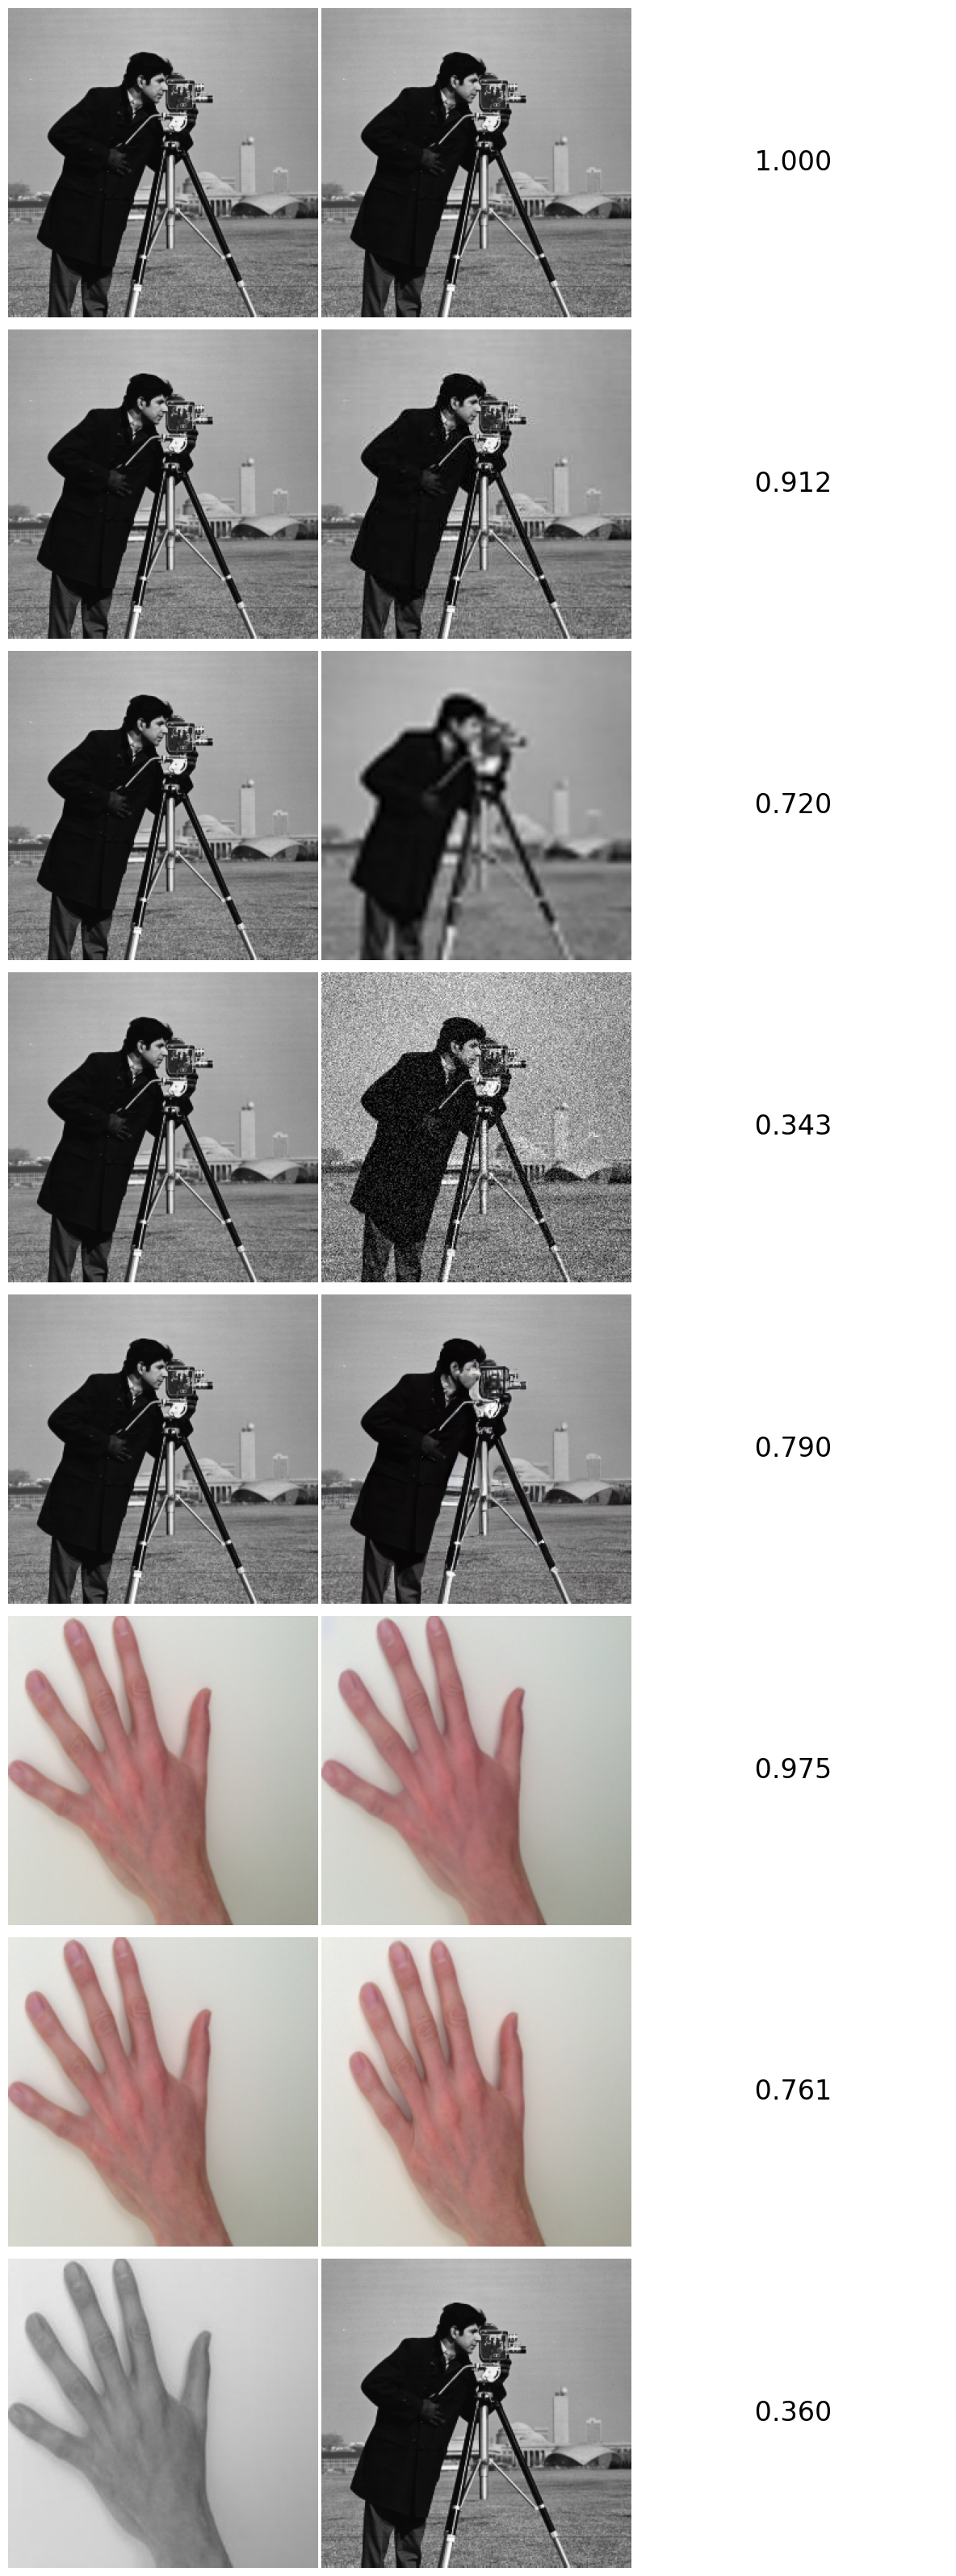

In [ ]:
"""Display the SSIM scores for the various image pairs"""

input_folder = '/hpc/group/youlab/ks723/storage/Random_images/SSIM_comparisions'  # Path with original images


# Define pairs with labels
pairs = [
    ("cameraman.tif", "cameraman.tif"),
    ("cameraman.tif", "cameraman_compressed.jpg"),
    ("cameraman.tif", "cameraman_downsampled.jpg"),
    ("cameraman.tif", "cameraman_noisy.jpg"),
    ("cameraman.tif", "cameraman_SDVAE.png"),  # Use the saved latent image
    ("hands1.jpg", "hands1_SDVAE.png"),
    ("hands1.jpg", "hands2.jpg"),
    ("hands1_resized_grayscale.jpg", "cameraman.tif")
]

# Prepare tensors for reference and comparison images
reference_images, comparison_images = [], []

for ref_label, comp_label in pairs:
    # Load images, including the saved latent images
    ref_image = Image.open(os.path.join(input_folder, ref_label)).convert("RGB")
    comp_image = Image.open(os.path.join(input_folder, comp_label)).convert("RGB")
    
    # Convert images to tensors
    ref_image = transform(ref_image).unsqueeze(0)
    comp_image = transform(comp_image).unsqueeze(0)

    # Resize for consistent comparison if mismatched
    if ref_image.shape != comp_image.shape:
        comp_image = F.resize(comp_image, ref_image.shape[-2:])
    
    reference_images.append(ref_image)
    comparison_images.append(comp_image)

# Display images with SSIM
display_images_with_ssim(reference_images, comparison_images, num_samples=len(pairs))


In [ ]:
# NOTE: Need to redo the comparison of the above files using JPEG compression metrics to get accurate comparison with fixed bpp values

In [ ]:
# BPP for SDVAE images
# 32x 32 x4 images, 32 bit precision
# bpp = (32 * 32 * 4 channels * 32bits) / (256 x 256 x 3 x 8bits)  # bits per pixel calculation

compression_bpp= 256 * 256 * 3 * 8 / (32 * 32 * 4 * 32)  # bits per pixel calculation
print(f"Compression ratio for SDVAE: {compression_bpp}")

bpp_sdvae= 24/compression_bpp  # 24= 8 bits per channel for 3 channels rgb
print(f"BPP for SDVAE images: {bpp_sdvae}")

Compression ratio for SDVAE: 12.0
BPP for SDVAE images: 2.0


In [ ]:
# compare the bpp results with jpeg compression 

from PIL import Image
import io
import os

def jpeg_bytes_and_bpp(img_path, quality):
    im = Image.open(img_path).convert("RGB")
    H, W = im.height, im.width
    buf = io.BytesIO()
    im.save(buf, "JPEG", quality=quality, subsampling=0, optimize=True,
            progressive=False)  # don't pass exif/icc
    data = buf.getvalue()
    bpp = (len(data)*8)/(H*W)
    return data, bpp

# Define images and qualities to test

image_file='/hpc/group/youlab/ks723/storage/Random_images/SSIM_comparisions/cameraman.tif'
qualities = [80, 85, 86,88, 90, 95]

print(f"JPEG Compression BPP results for {os.path.basename(image_file)}:")
for q in qualities:
    _, bpp = jpeg_bytes_and_bpp(image_file, quality=q)
    print(f"Quality: {q}, BPP: {bpp:.4f}")




JPEG Compression BPP results for cameraman.tif:
Quality: 80, BPP: 1.5488
Quality: 85, BPP: 1.8153
Quality: 86, BPP: 1.8912
Quality: 88, BPP: 2.0443
Quality: 90, BPP: 2.2372
Quality: 95, BPP: 3.1270
